# Q Learning
Reference: https://github.com/dennybritz/reinforcement-learning/blob/master/TD/Q-Learning%20Solution.ipynb

In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict
from forest import ForestEnv
import plotting
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

In [2]:
num_states = 16
env = ForestEnv(num_states=num_states)

In [3]:
def reconstruct_q_values(Q):
    q_values = np.zeros((env.observation_space.n, env.action_space.n))
    for k, v in Q.items():
        q_values[k] = v
    return q_values

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [5]:
def q_learning(env, num_episodes, discount_factor=0.9, alpha=0.1, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    sum_state_values = []
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 10 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            # Consistent with https://github.com/sawcordwell/pymdptoolbox/blob/master/src/mdptoolbox/mdp.py#L1062
            if done or t >= 100:
                break
                
            state = next_state
            
        sum_state_values.append(np.sum(np.max(reconstruct_q_values(Q), axis=1)))
    
    return Q, stats, sum_state_values

In [6]:
start_time = time.time()
Q, _, sum_state_values = q_learning(env, 2000)
end_time = time.time()
print('Time elapsed: {} seconds'.format(end_time - start_time))

Episode 2000/2000.Time elapsed: 12.742433071136475 seconds


Text(0, 0.5, 'Sum state values')

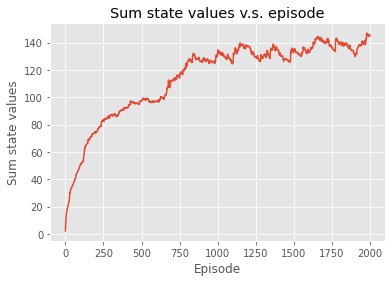

In [7]:
plt.plot(sum_state_values)
plt.title('Sum state values v.s. episode')
plt.xlabel('Episode')
plt.ylabel('Sum state values')

In [8]:
q_values = reconstruct_q_values(Q)

print("Q (state-action) values:")
print(q_values)

print("Policy (for each state):")
print(np.argmax(q_values, axis=1))

print("Value Function:")
print(np.max(q_values, axis=1))

Q (state-action) values:
[[ 4.44374205  3.94834054]
 [ 4.47415803  4.9729053 ]
 [ 4.53039703  4.97488636]
 [ 3.43541746  5.04035312]
 [ 1.62123196  5.05735342]
 [ 3.70472803  2.62851739]
 [ 4.05239617  2.87551635]
 [ 4.50464472  3.9033439 ]
 [ 4.57350773  5.05081617]
 [ 7.62817085  2.62923919]
 [ 9.8412747   4.1172824 ]
 [11.2759943   3.62205802]
 [12.4757812   4.11133639]
 [16.94969813  5.05773004]
 [21.09265898  4.44290904]
 [23.80374984  6.03679879]]
Policy (for each state):
[0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0]
Value Function:
[ 4.44374205  4.9729053   4.97488636  5.04035312  5.05735342  3.70472803
  4.05239617  4.50464472  5.05081617  7.62817085  9.8412747  11.2759943
 12.4757812  16.94969813 21.09265898 23.80374984]
